In [1]:
from google.colab import drive, auth
auth.authenticate_user()
drive.mount('./drive', force_remount=True, timeout_ms=300000)

Mounted at ./drive


In [2]:
!cp -r './drive/MyDrive/TI6/test' './test'

In [3]:
!cp -r './drive/MyDrive/TI6/modelo/model_gpu_oficial.h5' 'model_gpu_oficial.h5'

In [7]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping

import seaborn as sns

In [8]:
test_path = './test'

In [9]:
model = load_model('model_gpu_oficial.h5')

In [10]:
le = LabelEncoder()
le.classes_ = np.array(['Acne', 'Actinic', 'Atopic', 'Eczema', 'Light', 'Nail', 'Psoriasis', 'Seborrheic', 'Tinea', 'Warts'])

In [11]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

1/1 [==============================] - 0s 21ms/step


In [12]:
conf_matrix = confusion_matrix(real_label, predicted_class)

In [ ]:
plt.figure(figsize=(15, 15))  # Defina o tamanho da figura aqui
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

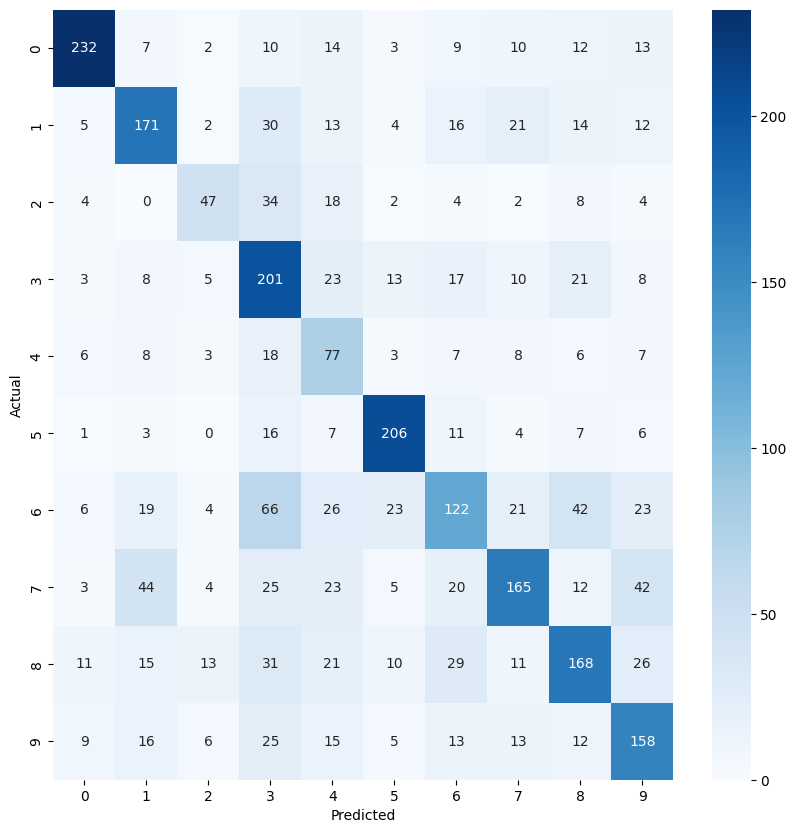

In [14]:
# Índices das linhas e colunas que deseja manter
linhas_para_manter = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
colunas_para_manter = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

# Criar uma submatriz com as linhas e colunas desejadas
submatriz = conf_matrix[linhas_para_manter][:, colunas_para_manter]

# Plotar a matriz de confusão
plt.figure(figsize=(10, 10))  # Defina o tamanho da figura aqui
sns.heatmap(submatriz, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
!nvidia-smi

Thu May 16 18:54:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0              31W /  70W |   4219MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Thu May 16 19:04:19 2024
Driver Version                            : 535.104.05
CUDA Version                              : 12.2

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : NVIDIA
    Product Architecture                  : Turing
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                

In [18]:
from numba import cuda

cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-e442d369-e108-8715-0ddf-0f4356f89162
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [20]:
cc_cores_per_SM_dict = {
    (2,0) : 32,
    (2,1) : 48,
    (3,0) : 192,
    (3,5) : 192,
    (3,7) : 192,
    (5,0) : 128,
    (5,2) : 128,
    (6,0) : 64,
    (6,1) : 128,
    (7,0) : 64,
    (7,5) : 64,
    (8,0) : 64,
    (8,6) : 128,
    (8,9) : 128,
    (9,0) : 128
    }
# the above dictionary should result in a value of "None" if a cc match
# is not found.  The dictionary needs to be extended as new devices become
# available, and currently does not account for all Jetson devices
device = cuda.get_current_device()
my_sms = getattr(device, 'MULTIPROCESSOR_COUNT')
my_cc = device.compute_capability
cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
total_cores = cores_per_sm*my_sms
print("GPU compute capability: " , my_cc)
print("GPU total number of SMs: " , my_sms)
print("total cores: " , total_cores)

GPU compute capability:  (7, 5)
GPU total number of SMs:  40
total cores:  2560


In [22]:
import torch

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Capability:", torch.cuda.get_device_capability(0))
    print("Total CUDA Cores:", torch.cuda.get_device_properties(0).multi_processor_count * 64)

GPU Name: Tesla T4
CUDA Capability: (7, 5)
Total CUDA Cores: 2560
